In [1]:
%reset -fs
import pandas as pd
import  numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from dask import dataframe as dd
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.options.mode.use_inf_as_na = True

In [2]:
#Dask !!!
ddf = dd.read_csv(r"C:\Users\nated\Downloads\CSV-01-12\01-12\DrDoS_LDAP.csv", dtype={'SimillarHTTP': 'object'},blocksize='64MB')
df = ddf.compute()

In [3]:
df.columns = df.columns.str.replace(' ', '')

In [4]:
(df['Label'].value_counts()) / len(df) * 100

DrDoS_LDAP    99.926107
BENIGN         0.073893
Name: Label, dtype: float64

In [5]:
df.drop(columns=['FlowID', 'SourceIP', 'DestinationIP', 'Timestamp', 'SimillarHTTP', 'SourcePort', 'DestinationPort'], inplace=True)

In [6]:
df.dropna(inplace=True)

In [7]:
cols = df.drop(columns=['Label']).columns.tolist()
for col in cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

In [8]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

In [9]:
X = df.drop(columns=["Label"], axis=1)
y = df['Label']


In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs', max_iter=1000000, n_jobs=-1)

In [11]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = .2, stratify=y)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, stratify=y_train_val)

In [13]:
X_train_scaled = pd.DataFrame(
    std.fit_transform(X_train),
    columns = X_train.columns)

In [14]:
import joblib
from dask.distributed import Client

client = Client(processes=False)

In [15]:
with joblib.parallel_backend("dask"):
    lr.fit(X_train_scaled, y_train)
    

In [16]:
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix

In [17]:
X_val_scaled = pd.DataFrame(std.transform(X_val), columns = X_val.columns)

In [18]:
y_val_preds = lr.predict(X_val_scaled)
print("With default decision threshold:")
print("Precision: {}, Recall: {}".format(precision_score(y_val, y_val_preds, pos_label='BENIGN'), recall_score(y_val, y_val_preds, pos_label='BENIGN')))

With default decision threshold:
Precision: 0.9011627906976745, Recall: 0.9717868338557993


In [19]:
import seaborn as sns

In [20]:
lr_confusion = confusion_matrix(y_val, y_val_preds, labels=['DrDoS_LDAP', 'BENIGN'])

In [35]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ["{0:0.0f}".format(value) for value in lr_confusion.flatten()]
group_percentages = ["{0:0.4%}".format(value) for value in lr_confusion.flatten()/np.sum(lr_confusion)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)

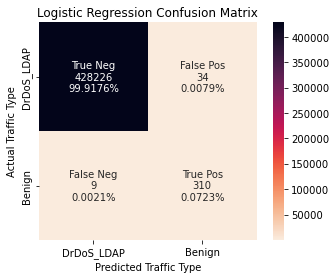

In [36]:
sns.heatmap(lr_confusion,cmap='rocket_r', annot=labels, fmt='', square=True, xticklabels=['DrDoS_LDAP', 'Benign'], yticklabels=['DrDoS_LDAP', 'Benign'])
plt.xlabel('Predicted Traffic Type')
plt.ylabel('Actual Traffic Type')
plt.title('Logistic Regression Confusion Matrix');

In [37]:
y_val.value_counts()

DrDoS_LDAP    428260
BENIGN           319
Name: Label, dtype: int64